<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment___6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import numpy as np

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:

image_path = 'viper.jpg'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


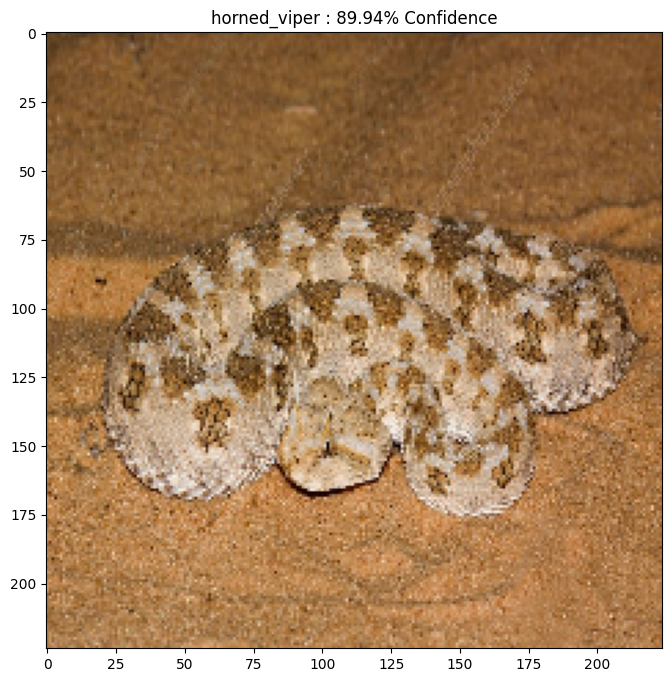

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the pertute35rbation
  signed_grad = tf.sign(gradient)
  return signed_grad

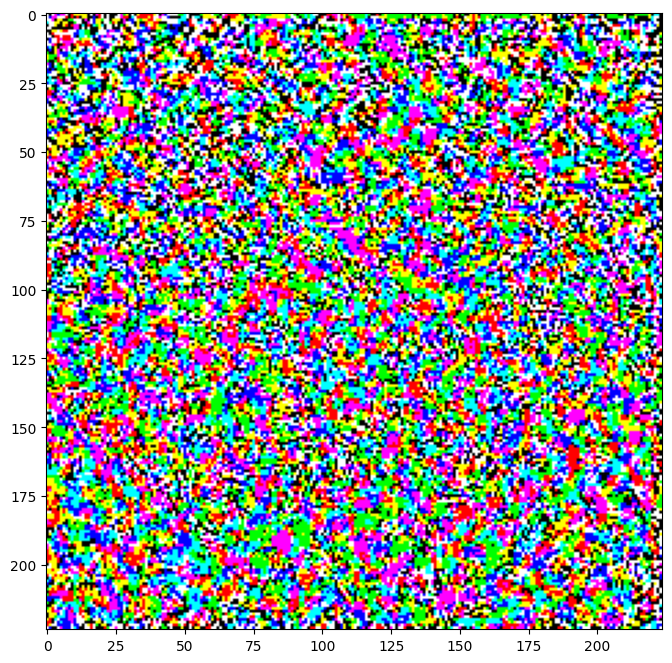

In [ ]:
# Get the input label of the image.
index = tf.argmax(image_probs[0])
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description , ind):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  # plt.figure()
  # pl.figure(figsize=(10, 10))
  plt.subplot(2, 2, ind)
  plt.imshow(image[0]*0.4+0.5)
  plt.title('{}  {} : {:.2f}% '.format(description,
                                                   label, confidence*100))
  plt.title('{}  {} : {:.2f}% '.format(description,
                                                   label, confidence*100))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


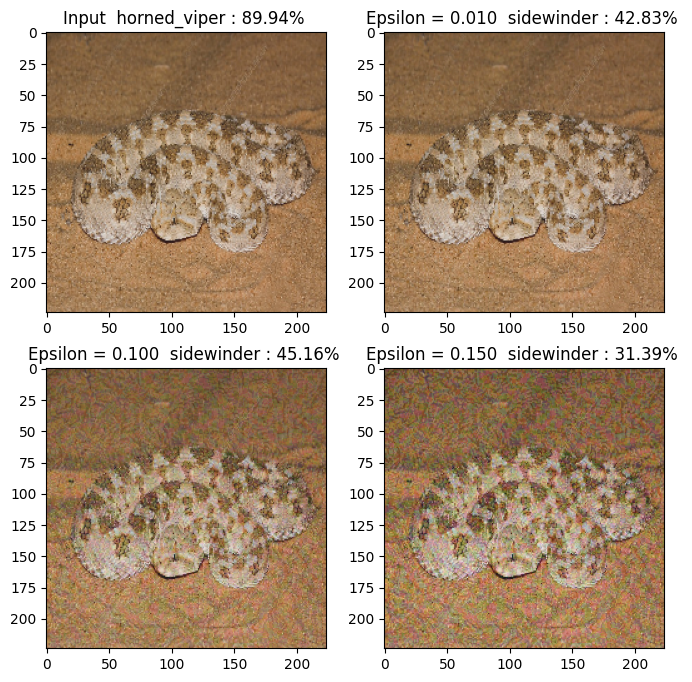

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')for eps in epsilons]
ind = 1;
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i], ind)
  ind += 1

plt.show()

In [ ]:
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# Display Grad-CAM
def display_gradcam_mobilenet(img_tensor, heatmap, model, image_title="Grad-CAM"):
    img = img_tensor[0].numpy()
    img = (img + 1.0) / 2.0  # un-normalize to [0, 1]
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(np.uint8(img * 255), 1.0, heatmap_color, 0.4, 0)
    preds = model.predict(img_tensor)
    class_id, label, confidence = decode_predictions(preds, top=1)[0][0]
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{image_title}: {label} ({confidence*100:.2f}%)")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_156']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


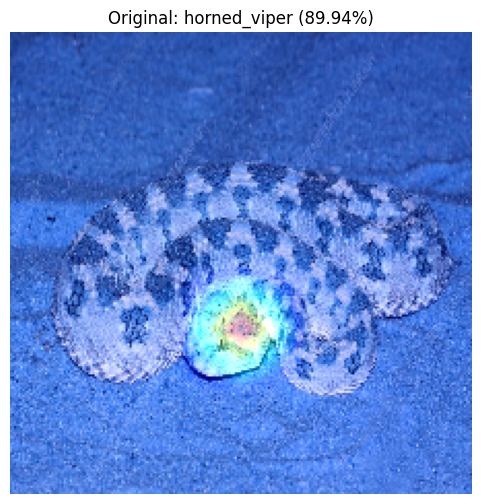

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_156']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


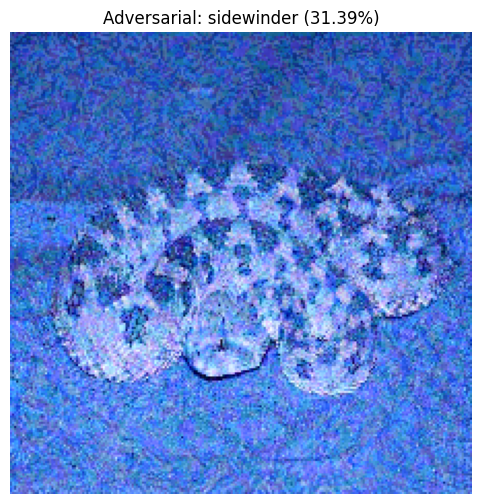

In [ ]:
# Grad-CAM on original
orig_class_idx = tf.argmax(pretrained_model.predict(image)[0])
heatmap_orig = make_gradcam_heatmap(image, pretrained_model, "block_16_project", orig_class_idx)
display_gradcam_mobilenet(image, heatmap_orig, pretrained_model, "Original")


# Grad-CAM on adversarial
epsilon = 0.15
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)
adv_class_idx = tf.argmax(pretrained_model.predict(adv_x)[0])
heatmap_adv = make_gradcam_heatmap(adv_x, pretrained_model, "block_16_project", adv_class_idx)
display_gradcam_mobilenet(adv_x, heatmap_adv, pretrained_model, "Adversarial")


In [ ]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    return baseline + alphas_x * delta

def compute_gradients(inputs, target_class_idx, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
        output = preds[:, target_class_idx]
    return tape.gradient(output, inputs)

def integrated_gradients(baseline, image, model, target_class_idx, m_steps=50):
    alphas = tf.linspace(0.0, 1.0, m_steps+1)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx, model)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0)
    ig = (image - baseline) * avg_grads
    return ig


In [ ]:
# Use zero image as baseline
baseline = tf.zeros(shape=image.shape)

# Original image
orig_ig = integrated_gradients(baseline, image, pretrained_model, orig_class_idx)
adv_ig = integrated_gradients(baseline, adv_x, pretrained_model, adv_class_idx)


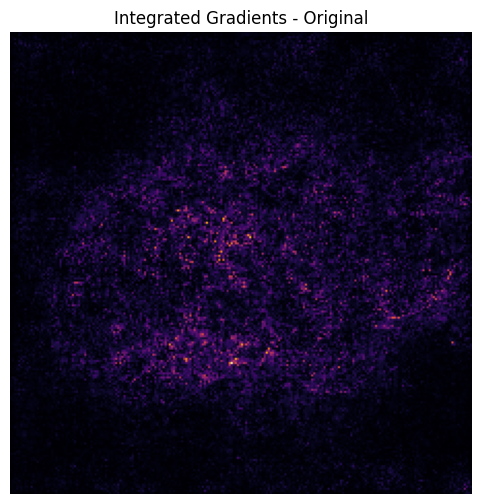

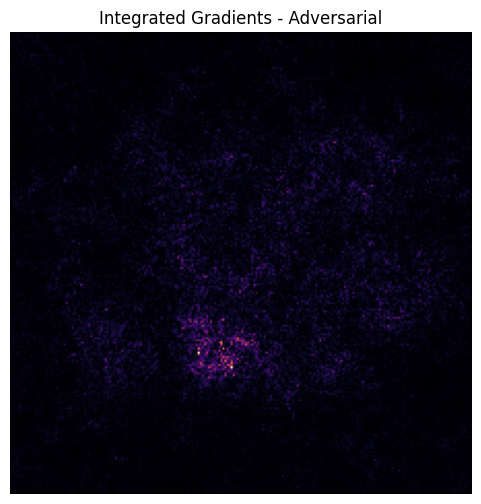

In [ ]:
def plot_ig(ig_attributions, title):
    attributions = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)[0]
    attributions = attributions / tf.reduce_max(attributions)
    plt.figure(figsize=(6, 6))
    plt.imshow(attributions, cmap='inferno')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_ig(orig_ig, "Integrated Gradients - Original")
plot_ig(adv_ig, "Integrated Gradients - Adversarial")


In [ ]:
import tensorflow as tf

# Load full model (with softmax)
mobilenet_softmax = tf.keras.applications.MobileNetV2(weights='imagenet')
mobilenet_softmax.trainable = False

# Remove the softmax to get logits model
# Last Dense layer is usually 2 layers before the end
mobilenet_logits = tf.keras.Model(
    inputs=mobilenet_softmax.input,
    outputs=mobilenet_softmax.get_layer("predictions").output  # or use correct dense layer name if needed
)

In [ ]:
for layer in mobilenet_softmax.layers[::-1]:
    print(layer.name)

predictions
global_average_pooling2d_3
out_relu
Conv_1_bn
Conv_1
block_16_project_BN
block_16_project
block_16_depthwise_relu
block_16_depthwise_BN
block_16_depthwise
block_16_expand_relu
block_16_expand_BN
block_16_expand
block_15_add
block_15_project_BN
block_15_project
block_15_depthwise_relu
block_15_depthwise_BN
block_15_depthwise
block_15_expand_relu
block_15_expand_BN
block_15_expand
block_14_add
block_14_project_BN
block_14_project
block_14_depthwise_relu
block_14_depthwise_BN
block_14_depthwise
block_14_expand_relu
block_14_expand_BN
block_14_expand
block_13_project_BN
block_13_project
block_13_depthwise_relu
block_13_depthwise_BN
block_13_depthwise
block_13_pad
block_13_expand_relu
block_13_expand_BN
block_13_expand
block_12_add
block_12_project_BN
block_12_project
block_12_depthwise_relu
block_12_depthwise_BN
block_12_depthwise
block_12_expand_relu
block_12_expand_BN
block_12_expand
block_11_add
block_11_project_BN
block_11_project
block_11_depthwise_relu
block_11_depthwise_

In [ ]:
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


# Use original image
img = image  # Already preprocessed input

# Get class index from original model
class_idx = tf.argmax(mobilenet_softmax.predict(img)[0])

# Grad-CAM with softmax
heatmap_softmax = make_gradcam_heatmap(img, mobilenet_softmax, "block_16_project", class_idx)

# Grad-CAM with logits
heatmap_logits = make_gradcam_heatmap(img, mobilenet_logits, "block_16_project", class_idx)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_468']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_468']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


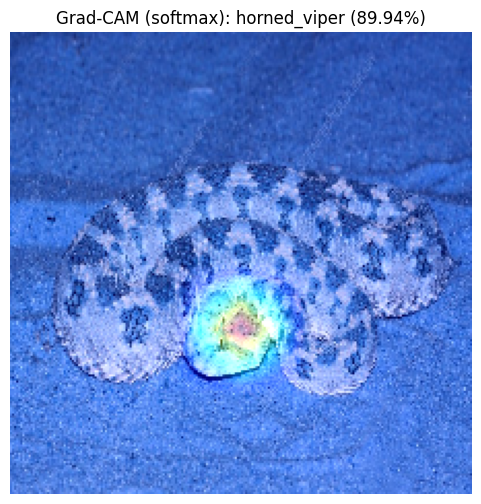

In [ ]:
display_gradcam_mobilenet(img, heatmap_softmax, mobilenet_softmax, "Grad-CAM (softmax)")


In [ ]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    return baseline + alphas_x * delta

def compute_gradients(inputs, target_class_idx, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
        output = preds[:, target_class_idx]
    return tape.gradient(output, inputs)

def integrated_gradients(baseline, image, model, target_class_idx, m_steps=50):
    alphas = tf.linspace(0.0, 1.0, m_steps+1)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx, model)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0)
    ig = (image - baseline) * avg_grads
    return ig
baseline = tf.zeros_like(image)
class_idx = tf.argmax(mobilenet_softmax.predict(image)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


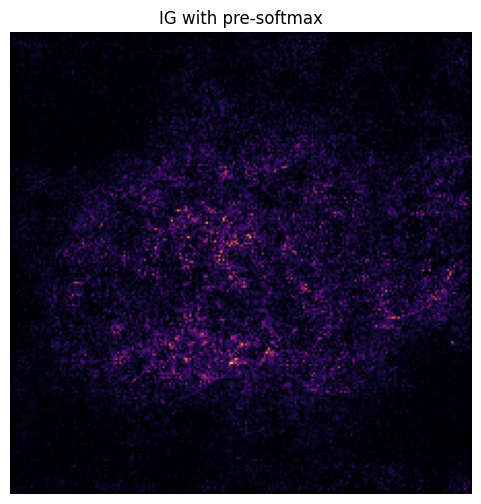

In [ ]:
# IG with softmax
ig_softmax = integrated_gradients(baseline, image, mobilenet_softmax, class_idx)

# IG with logits
ig_logits = integrated_gradients(baseline, image, mobilenet_logits, class_idx)
def plot_ig(ig_attributions, title):
    attributions = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)[0]
    attributions = attributions / tf.reduce_max(attributions + tf.keras.backend.epsilon())
    plt.figure(figsize=(6, 6))
    plt.imshow(attributions, cmap='inferno')
    plt.axis('off')
    plt.title(title)
    plt.show()
# plot_ig(ig_softmax, "IG with Softmax")
plot_ig(ig_logits, "IG with pre-softmax")
